In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/kaggle/input/mobile-games-ab-testing/cookie_cats.csv")
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


# Business Question 

## Contex : 

Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level

As players progress through the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress. In addition **to driving in-app purchases**, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged.

But **where should the gates be placed?** **Initially** the first gate was placed at **level 30**, but in this notebook we're going to analyze an AB-test where we **moved** the first gate in Cookie Cats **from level 30(Control) to level 40 (Treatment)**. In particular, we will look at the impact on player retention. 


## Business Question : 
1. ***Retention Rate  (Main Metrics) ***

Usually, when we have Retention rate as our main metrics, we have secondary metrics as follows :
1. Activation Rate
2. Churn Rate 
3. Revenue Per Customer

We have Counter Metrics as follow : 
1. Customer Acuqisition Cost (CAC)
2. Complaint 





# 

In [3]:
#Data Preparation
retention_change = {False: 0,
                   True : 1}

df.replace({"retention_1" :retention_change,
            "retention_7" : retention_change},inplace = True)




#We change this categorical variabel so that it's going to be easier for us to do analysis

In [4]:
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1
...,...,...,...,...,...
90184,9999441,gate_40,97,1,0
90185,9999479,gate_40,30,0,0
90186,9999710,gate_30,28,1,0
90187,9999768,gate_40,51,1,0


## Exploratory Data Analysis

In [5]:
#The length of the data 
print( "The total of the data rows are :",len(df))

The total of the data rows are : 90189


In [6]:
#How many user_id are there 
print("The total user_id are :",df["userid"].nunique() )


The total user_id are : 90189


In [7]:
#Is there anyone with zero sum_game?

df[df["sum_gamerounds"]==0]
#yes they are, we need to remove this because our main objective is retention, while this user_id is not playing

df =df[df["sum_gamerounds"]!= 0 ]


In [8]:
#Proportion for Control And Treatment ()

round ((df["version"].value_counts() /len(df)) * 100 ,2)

#we see that the proportion is equal (even though not identical) 

gate_40    50.39
gate_30    49.61
Name: version, dtype: float64

In [9]:
#sum_gamerounds for Control vs Treatment

round(df.groupby("version")["sum_gamerounds"].sum() / sum(df["sum_gamerounds"]) * 100,2)

version
gate_30    50.12
gate_40    49.88
Name: sum_gamerounds, dtype: float64

In [10]:
#What is the average retention for control data ?
print ("The average retention_1 for our control is :",round(df[df["version"] == "gate_30"]["retention_1"].mean() * 100,2).astype('str')+"%")
print ("The average retention_7 for our control is :",round(df[df["version"] == "gate_30"]["retention_7"].mean() * 100,2).astype('str')+"%")

The average retention_1 for our control is : 46.75%
The average retention_7 for our control is : 19.84%


In [11]:
#What is the average retention for Treatment data ?
print ("The average retention_1 for our treatment is :",round(df[df["version"] == "gate_40"]["retention_1"].mean() * 100,2).astype('str')+"%")
print ("The average retention_7 for our treatment is :",round(df[df["version"] == "gate_40"]["retention_7"].mean() * 100,2).astype('str')+"%")

The average retention_1 for our treatment is : 46.22%
The average retention_7 for our treatment is : 19.03%


We see that the average between control and treatment have a very small difference, and it's easy to assume if there is no statistical difference. But it might be because it comes from 1 sample. We will use bootstrap and combine it with t-test to see if there is any signifiance difference in the future.

# Hypothesis Testing

In [12]:
bootstrap_size = 300

retention_1_list = []
retention_7_list = []


for i in range (bootstrap_size):
    retention_1 = df.sample(frac=1, replace=True).groupby("version")['retention_1'].mean()
    retention_1_list.append(retention_1)
    retention_7 = df.sample(frac = 1, replace = True).groupby("version")["retention_7"].mean()
    retention_7_list.append(retention_7)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


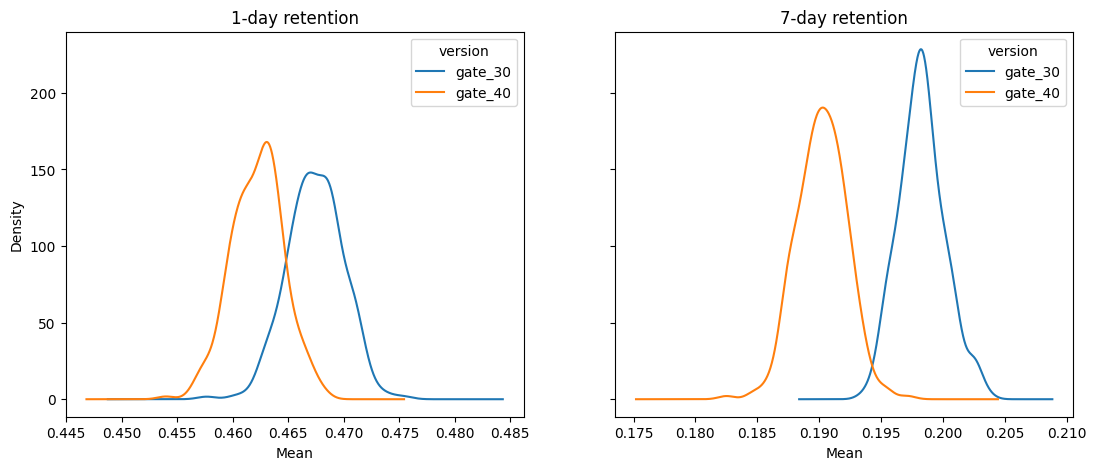

In [13]:
#make into dataframe 
bootstrap_retention_1 = pd.DataFrame (retention_1_list)
bootstrap_retention_7 = pd.DataFrame(retention_7_list)

fig, (ax1,ax2) = plt.subplots(1,2, sharey = True ,figsize = (13,5))
bootstrap_retention_1.plot.kde(ax = ax1)
ax1.set_title("1-day retention")
ax1.set_xlabel("Mean")
bootstrap_retention_7.plot.kde(ax = ax2 )
ax2.set_title("7-day retention")
ax2.set_xlabel("Mean")
plt.show()


In [14]:
import scipy.stats as stats
bootstrap_retention_1

t_statistic, p_value = stats.ttest_ind(bootstrap_retention_1["gate_30"], bootstrap_retention_1["gate_40"],alternative = "greater")
# Print the results
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: 26.35873445223891
P-Value: 1.714340618345465e-102


In [15]:
t_statistic, p_value = stats.ttest_ind(bootstrap_retention_7["gate_30"], bootstrap_retention_7["gate_40"],alternative = "greater")
# Print the results
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: 51.29272308647506
P-Value: 1.9110457017776168e-221


### Retention_1 : 
H0 : mean_control >= mean_treatment 

H1 : mean_control < mean_treatment 

p_value = 0.05 ; 

we see that our data p-value as follow : (8.6e-128) < 0.05.
Hence, since it's smaller than p-value, we reject H0. We can conclude if there is a **signifiance mean difference between the group**.
However, by seeing the graph above, we can see that the **mean difference is getting worst**. So, we will **stay using the gate_30 (control)**






### Retention_7 : 
H0 : mean_control >= mean_treatment 

H1 : mean_control < mean_treatment

p_value = 0.05 

we see that our data p-value as follow : (1.3e-227) < 0.05.
Hence, since it's smaller than p-value, we reject H0. We can conclude if there is a **signifiance mean difference between the group**.
However, by seeing the graph above, we can see that the **mean difference is getting worst**. So, we will **stay using the gate_30 (control)**


